# Summary

# Goal
This goal of this analysis is to:
1. Assess the stability of the 60 GHz radio link performance
2. Detect anomalies in the last mile latency of the 60 GHz radio network (interpretation will be the next step)

## Research Questions:
1. Are the last mile latency and the throughput of our 60 GHz radio link volatile? If so, how much more compared with the wired connection?
2. Can we effectively detect anomalies in the last mile latency of our 60GHz radio link?
3. When those anomalies in the last mile latency of our 60GHz link occur, do we also observe variations in the wired part?
4. (To-do) When those anomalies in the last mile latency of our 60GHz link occur, do we also observe variations in the throughputs of our radio link as well?
5. (To-do) For those anomalies, do they occur in a continuous or discrete manner?


## Methodologies
- **Metrics of focus:**    
    1. Average last mile latency 
    2. Download throughput (taking the maximal value between ookla and ndt7)
    3. Upload throughput (taking the maximal value between ookla and ndt7)
- **Analysis Framework**    
    Comparing the distribution of the metric between the wired + 60GHz (V1000) and the wired connection (V5000) 
- **Anomaly Detection Method**    
    Two sigma rule (result cross-checked with Facebook Prophet algorithm)

## Key Takeaways:
1. Are the last mile latency and the throughput of our 60 GHz radio link volatile compared with the wired connection?
> Yes. The 60 GHz radio link (V1000) is more volatile and has noticeably more outliers in both the last mile latency and throughput metric than the wired upstream (V5000).  
2. Can we effectively detect anomalies in the last mile latency of our 60GHz radio link?
> Since the time series RPI data has no significant trend or seasonality, we can use the interpretable [two-sigma rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) to detect anomalies. (The anomalies here are defined as those data points that are **2 standard deviations** away from the **mean** *(i.e. These data points have very small chances (~5%) of occurrence, so when these rare events do occur, they are defined as anomalies.)*
3. When those anomalies in the last mile latency of our 60GHz link occur, do we also observe variations in the wired part?
> In the past 5 days, we identify **28** anomalies in the average last mile latency, **2** of them also come with an abnormal spike in the wired part => worth deep-diving.

Updated 10 PM, 07/27

In [3]:
# !pip install influxdb_client

In [14]:
import pandas as pd
import numpy as np
import json,os
from glob import glob
from datetime import datetime,date,timedelta
import argparse
from influxdb_client import InfluxDBClient

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
# This gives me the white canvas, ticks, also the Arial font family
sns.set_context('talk') 
style.use('seaborn-deep')

import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.io as pio
from plotly.subplots import make_subplots
pio.templates.default = "none"

import warnings
warnings.simplefilter('ignore')

# Data Pipeline (from InfluxDB)

In [5]:
# !pip install influxdb_client

port = 9096
token = '6CFrpH6uZtKkVLCrMNjm68Sq_g0WH3kGlNPt9W4QY61Lxd8EZkWb0vA93KifyYC63msfExAetb6g_ppNhgULpg=='
org = 'CDAC'
start = '2022-07-22T00:00:00Z'
stop = '2022-07-27T00:00:00Z'

config = dict({
    'port' : port,
    'org' : org,
    'token':token,
    'start' : start,
    'stop' : stop    
})

In [51]:
class Client:

    def __init__(self, config):

        # # Initialize client to query DB
        # with open(config, "r") as f:
        #     c = yaml.safe_load(f)

        self.client = InfluxDBClient(url=f'https://wilson.cs.uchicago.edu:{config["port"]}',
                                     token=config['token'], org=config['org'])

        self.base_query = (f'from(bucket:"netrics-prod0")'                        
                       f'|> range(start: {config["start"]}, stop: {config["stop"]})')


    def ookla(self):
        """ Returns ookla speedtest data between 'start' and 'stop' for all devices
            or a single device. TODO: allow to give list of devices """

        query = self.base_query + """
                    |> filter(fn: (r) => (r._field == "speedtest_ookla_download" or r._field == "speedtest_ookla_upload"))
                    |> drop(columns:["meta_extended", "meta_extended_debhash", "meta_extended_dataver", "env", "_start","_stop"])
                    |> filter(fn: (r) => (r.install == "nm-mngd-20210518-0ca06c37" or r.install == "nm-mngd-20220628-07c02d28"))
                 """

        df = self.exec_query(query)

        df["_field"].replace({"speedtest_ookla_download": "download",
                              "speedtest_ookla_upload": "upload"}, inplace=True)

        df = df.rename(columns={"_time": "Time", "_value": "Speed",
                                "_field": "Direction", "_measurement": "Tool",
                                "install": "ID"})

        df['Tool'] = df['Tool'].replace(['oplat'], 'iPerf3 (TCP)')
        df['Tool'] = df['Tool'].replace(['iperf'], 'iPerf3 (UDP)')

        return df

    def ndt(self):
        """ Returns ndt speedtest data between 'start' and 'stop' for all devices
            or a single device. TODO: allow to give list of devices """


        query = self.base_query + """
                    |> filter(fn: (r) => (r._field == "speedtest_ndt7_download" or r._field == "speedtest_ndt7_upload"))
                    |> filter(fn: (r) => (r.install == "nm-mngd-20210518-0ca06c37" or r.install == "nm-mngd-20220628-07c02d28"))
                    |> drop(columns:["meta_extended", "meta_extended_debhash", "meta_extended_dataver", "env", "_start","_stop"])                    
                    """

        df = self.exec_query(query)

        df["_field"].replace({"speedtest_ndt7_download": "download",
                              "speedtest_ndt7_upload": "upload"}, inplace=True)

        df = df.rename(columns={"_time": "Time", "_value": "Speed (Mb/s)",
                                "_field": "Direction", "_measurement": "Tool"})

        return df

    def speedtest(self):
        """ Returns all speedtest data between 'start' and 'stop' for all devices
            or a single device. TODO: allow to give list of devices """

        query = self.base_query + """
                    |> filter(fn: (r) => (r._field == "speedtest_ndt7_download" or r._field == "speedtest_ndt7_upload" or
                                          r._field == "speedtest_ookla_download" or r._field == "speedtest_ookla_upload") or
                                          r._field == "avg_rate_icmp_probes_dl" or r._field == "avg_rate_icmp_probes_ul")
                    |> filter(fn: (r) => (r.install == "nm-mngd-20210518-0ca06c37" or r.install == "nm-mngd-20220628-07c02d28"))                      
                    |> map(fn:(r) => ({ r with _time: time(v:r._time) }))
                    |> drop(columns:["meta_extended", "meta_extended_debhash", "meta_extended_dataver", "env", "_start","_stop"])
                 """

        df = self.exec_query(query)

        df["_field"].replace({"speedtest_ndt7_download": "download",
                              "speedtest_ndt7_upload": "upload",
                              "speedtest_ookla_download": "download",
                              "speedtest_ookla_upload": "upload",
                              "avg_rate_icmp_probes_dl": "download",
                              "avg_rate_icmp_probes_ul": "upload"}, inplace=True)
        df = df.rename(columns={"_time": "Time", "_value": "Speed",
                                "_field": "Direction", "_measurement": "Tool",
                                "install": "ID"})

        return df
    
    def ping_latency(self):
        """ Returns latency/ping data between 'start' and 'stop'"""

        query = self.base_query + ('|> filter(fn: (r) => (r._field == "Cloudflare_DNS_last_mile_ping_rtt_avg_ms" or '
                                        'r._field == "google_rtt_min_ms" or '
                                        'r._field == "google_rtt_avg_ms" or '
                                        'r._field == "uchicago_rtt_avg_ms" or '
                                        'r._field == "amazon_rtt_avg_ms" or '
                                        'r._field == "youtube_rtt_avg_ms" or '
                                        'r._field == "facebook_rtt_avg_ms" or '
                                        'r._field == "wikipedia_rtt_avg_ms" or '
                                        'r._field == "tribune_rtt_avg_ms" or '
                                        'r._field == "suntimes_rtt_avg_ms" or '
                                        'r._field == "Washington_DC_rtt_avg_ms" or '
                                        'r._field == "Atlanta_rtt_avg_ms" or '
                                        'r._field == "Denver_rtt_avg_ms"))'
                                   '|> filter(fn: (r) => (r.install == "nm-mngd-20210518-0ca06c37" or r.install == "nm-mngd-20220628-07c02d28"))'
                '|> drop(columns:["meta_extended", "meta_extended_debhash", "meta_extended_dataver", "env", "_start","_stop"])')

        df = self.exec_query(query)

        df = df.rename(columns={"_time": "Time", "_value": "RTT",
                                "_measurement": "Measurement",
                                "install": "ID"})
        df['Destination'] = df['_field'].apply(lambda x: 'Last Mile' if "Cloudflare" in x else x.split('_')[0])
        df['Method'] = df['_field'].apply(lambda x: 'Avg' if 'avg' in x else 'Min')
        df.drop(['_field'], axis=1, inplace=True)

        return df

    def latency_under_load(self):
        """
        Returns latency under load data between 'start' and 'stop'
        """

        query = self.base_query + ('|> filter(fn: (r) => (r._field == "loaded_icmp_abbot.cs.uchicago.edu_avg_rtt_ms_dl" or '
                  'r._field == "loaded_icmp_abbott.cs.uchicago.edu_avg_rtt_ms_ul" or '
                  'r._field == "loaded_tcp_abbott.cs.uchicago.edu_avg_rtt_ms_ul" or '
                  'r._field == "loaded_tcp_abbott.cs.uchicago.edu_avg_rtt_ms_dl"))'           
                  '|> filter(fn: (r) => (r.install == "nm-mngd-20210518-0ca06c37" or r.install == "nm-mngd-20220628-07c02d28"))'
                  '|> drop(columns:["meta_extended", "meta_extended_debhash", "meta_extended_dataver", "env", "_start", "_stop", "name"])')

        df = self.exec_query(query)

        df = df.rename(columns={"_time": "Time", "_value": "RTT",
                                "_field": "Test", "_measurement": "Measurement",
                                "install": "ID"})

        df['Protocol'] = df.apply(process_oplat_proto, axis=1)
        df['Direction'] = df.apply(process_oplat_dir, axis=1)
        df.drop(['Test'], axis=1, inplace=True)

        df['Destination'] = 'abbott.cs.uchicago.edu'

        return df


    def exec_query(self, query):
        """ Executes 'query' and returns dataframe """
        df = self.client.query_api().query_data_frame(query).drop(["result", "table"], axis=1)
        return df


def process_oplat_proto(row):
    if "icmp" in row['Test']:
        return "icmp"
    elif "tcp" in row['Test']:
        return "tcp"


def process_oplat_dir(row):
    if "dl" in row['Test']:
        return 'download'
    elif "ul" in row['Test']:
        return "upload"


def convert_time(df):
    df["Time"] = pd.to_datetime(df["Time"])
    df = df.set_index("Time")
    return df.tz_convert('US/Central').reset_index()

def main():

    # Initialize client to query DB
    c = Client(config)
    convert_time(c.speedtest()).to_csv("speedtest.csv")
    convert_time(c.latency_under_load()).to_csv("lul.csv")
    convert_time(c.ping_latency()).to_csv("ping_latency.csv")


if __name__ == "__main__":
    main()

In [52]:
def view(df):
    # Exploring the data types, number of unique values and missing values
    cols = df.columns
    print(f"The dataset consists of {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"The columns are: {df.columns.tolist()}")
    return pd.concat([pd.DataFrame({
        "data_types":df.dtypes, 
              "value_counts": df.nunique(),
             "null_counts": df.isnull().sum()}).T,df.iloc[0:3,:]],axis = 0)

In [59]:
# Read in the file
speed = pd.read_csv("speedtest.csv",index_col = 0)
latency = pd.read_csv("ping_latency.csv",index_col = 0)
lux = pd.read_csv("lul.csv",index_col = 0)

In [60]:
# Preprocessing

# For the speed test data, we want to mitigate the collection error caused by tools, so we take the max of the ookla and ndt7
speed['pi'] = list(map(lambda x:'v5000' if x[-4:]=='2d28' else 'v1000', speed['ID']))
speed['datetime'] = list(map(lambda x:x.split('.')[0], speed['Time']))
speed_df = speed[speed.Tool.isin(['ookla','ndt7'])].groupby(['datetime','pi','Direction']).Speed.max().reset_index()
speed_df.columns = ['datetime','pi','direction','speed']

# For the latency test data, we currently focus on the last mile latency 
latency['pi'] = list(map(lambda x:'v5000' if x[-4:]=='2d28' else 'v1000', latency['ID']))
latency['datetime'] = list(map(lambda x:x.split('.')[0], latency['Time']))
lml_df = latency.loc[latency.Measurement == 'last_mile_rtt',['datetime','pi','RTT']]
lml_df.columns = ['datetime','pi','last_mile_latency']

# Print the size of the test data
print(f"Number of speed test data records for the two pis (including download and upload): {speed_df.shape[0]}; \nNumber of last mile latency test records for the two pis: {lml_df.shape[0]}")

Number of speed test data records for the two pis (including download and upload): 790; 
Number of last mile latency test records for the two pis: 2645


In [11]:
view(speed_df)

The dataset consists of 2349 rows and 5 columns
The columns are: ['Time', 'Direction', 'Tool', 'Speed', 'ID']


,Time,Direction,Tool,Speed,ID
data_types,object,object,object,float64,object
value_counts,395,2,3,2349,2
null_counts,0,0,0,0,0
0,2022-07-22 14:46:11.218748-05:00,download,oplat,864.460439,nm-mngd-20210518-0ca06c37
1,2022-07-22 15:16:15.572479-05:00,download,oplat,855.436076,nm-mngd-20210518-0ca06c37
2,2022-07-22 15:46:10.852515-05:00,download,oplat,801.053614,nm-mngd-20210518-0ca06c37


In [54]:
view(lml_df)

The dataset consists of 2645 rows and 3 columns
The columns are: ['datetime', 'pi', 'last_mile_latency']


,datetime,pi,last_mile_latency
data_types,object,object,float64
value_counts,2366,2,873
null_counts,0,0,0
2645,2022-07-22 14:36:02,v1000,1.536
2646,2022-07-22 14:41:03,v1000,1.527
2647,2022-07-22 14:46:05,v1000,1.698


# Anomaly Detection

## Last Mile Latency

### Exploring the Trend (Re-cap)
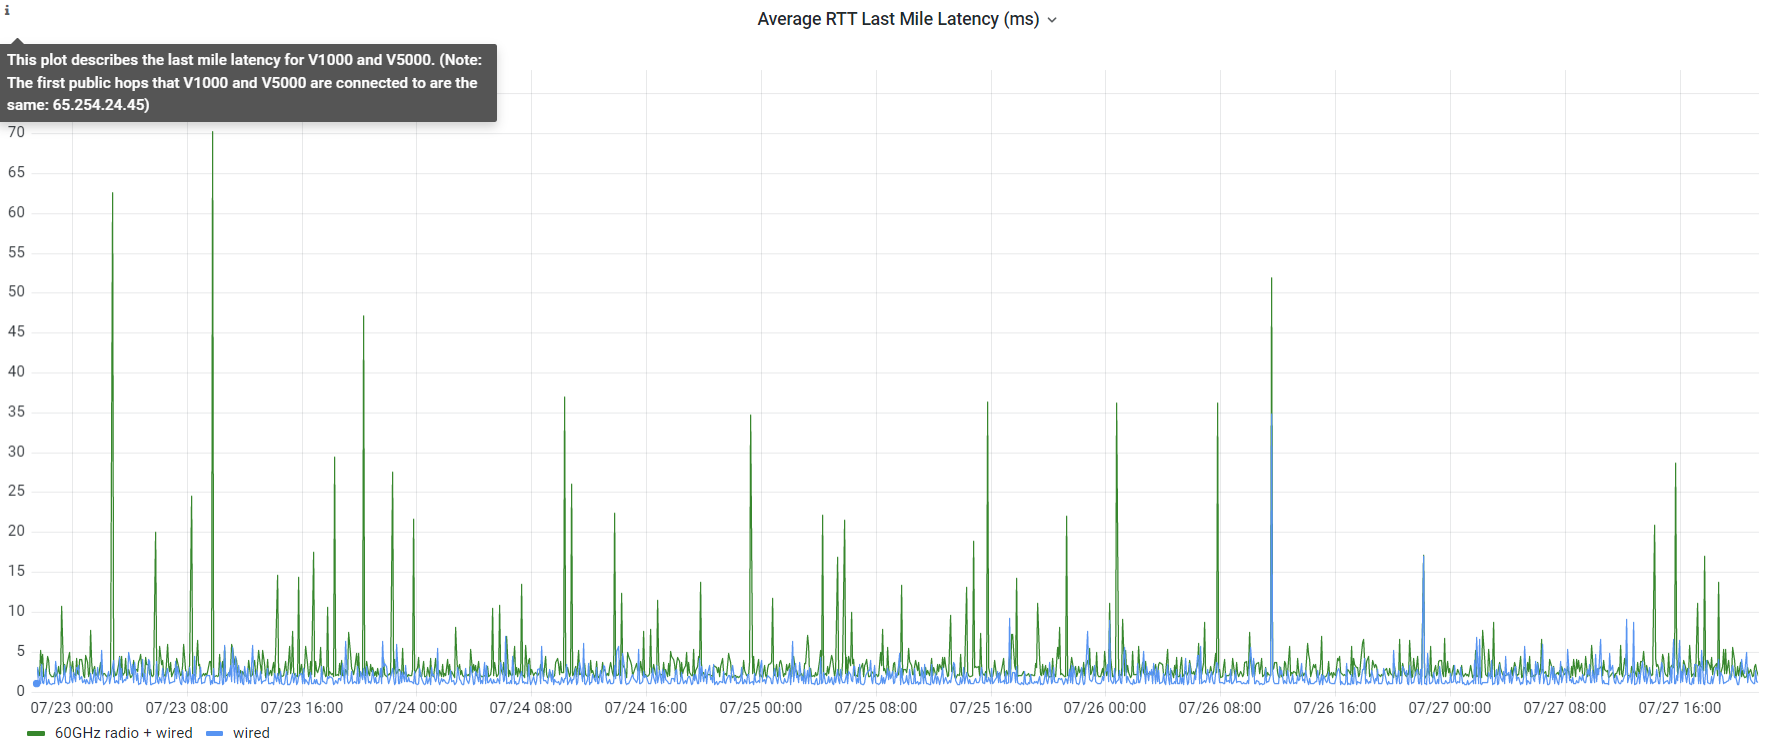


In [77]:
from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(df, col):
    '''
    The null hypothesis of DF test is that there is a unit root in an AR model, which implies that the data series is not stationary. 

    p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
    '''
    print(f"Augmented Dickey-Fuller (ADF) Test: {col}")
    result = adfuller(df[col].dropna().values)
    print('ADF Statistic: %f' % result[0])
    print("Used Lag: ",result[2])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print("----------------------------------------")
    if result[1] <= 0.05:
        print(f" => P-Value = {result[1]}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {result[1]}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

# ADF Test
for col in ['last_mile_latency']:
    augmented_dickey_fuller_test(lml_df[lml_df.pi == 'v1000'], col)
# Print conclusion
print("----------------------------------------")
print("CONCLUSION: The average last mile latency for V1000 has no trend or seasonality.")

Augmented Dickey-Fuller (ADF) Test: last_mile_latency
ADF Statistic: -8.665423
Used Lag:  17
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
----------------------------------------
 => P-Value = 4.698764764420638e-14. Rejecting Null Hypothesis.
 => Series is Stationary.
----------------------------------------
CONCLUSION: The average last mile latency for V1000 has no trend or seasonality.


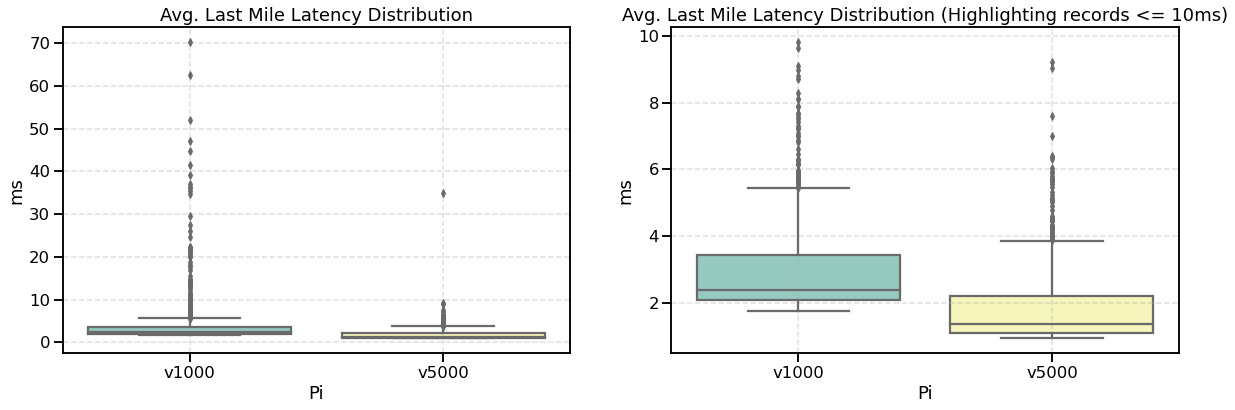

In [87]:
# Test outliers
f,axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.boxplot(x = 'pi', y = 'last_mile_latency', data = lml_df, palette="Set3", ax = axes[0])
axes[0].set_title("Avg. Last Mile Latency Distribution")
axes[0].set_ylabel("ms")
axes[0].set_xlabel("Pi")
axes[0].grid(linestyle = "--", alpha=0.4)

sns.boxplot(x = 'pi', y = 'last_mile_latency', data = lml_df[lml_df['last_mile_latency']<=10], palette="Set3", ax = axes[1])
axes[1].set_title("Avg. Last Mile Latency Distribution (Highlighting records <= 10ms)")
axes[1].set_ylabel("ms")
axes[1].set_xlabel("Pi")
axes[1].grid(linestyle = "--", alpha=0.4)
plt.show()

In [208]:
stat = lml_df.groupby('pi').agg(
    var_last_mile_latency=pd.NamedAgg(column='last_mile_latency', aggfunc=np.var),
    mean_last_mile_latency=pd.NamedAgg(column='last_mile_latency', aggfunc=np.mean),
)
stat['cv_last_mile_latency'] = stat['var_last_mile_latency']/stat['mean_last_mile_latency']
stat

,var_last_mile_latency,mean_last_mile_latency,cv_last_mile_latency
pi,,,
v1000,23.219556,3.623550,6.407957
v5000,1.943355,1.816061,1.070094


### Anomaly Detection

In [185]:
def plot_lml_three_sigma_detection(df, last_x_days, date_col, y_col, num_sigma = 2):
    '''
    Input:
        ...
    Output:
        fig1 (Plotly.graph figure object)
    '''    
    # filter out the anomaly records according to the user-specified thresholds
    data = df.loc[(df[date_col]>=(datetime.now()-timedelta(days=last_x_days)).strftime("%Y-%m-%d %H:%M:%S"))&(df.pi == 'v1000'),
                  [date_col,y_col]]
    v5000_data = df.loc[(df[date_col]>=(datetime.now()-timedelta(days=last_x_days)).strftime("%Y-%m-%d %H:%M:%S"))&(df.pi == 'v5000'),
                  [date_col,y_col]]    
    
    x = list(data[date_col])
    x_rev = x[::-1]
    y = list(data[y_col])
    y_upper = [(np.mean(y)+num_sigma*np.std(y))]*len(y)
    y_lower = [(np.mean(y)-num_sigma*np.std(y))]*len(y)
    # y_lower = y_lower[::-1]

    layout = Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig1 = go.Figure(layout = layout)
    # add the filled region
    fig1.add_trace(go.Scatter(
        x=x+x_rev,
        y=y_upper+y_lower,
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line_color='rgba(255,255,255,0)',
        showlegend=False,
        hoverinfo='skip'
    ))
    # add the actual line - V1000
    fig1.add_trace(go.Scatter(
        x=x, y=y,
        line_color='rgb(0,100,80)',
        name='Wired + 60 GHz',
        showlegend=False,
        hovertemplate =
          '<b>Wired + 60 GHz</b>' +
          '<br><b>Last Mile Latency: </b> %{y} ms'+
          '<br><b>Datetime: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
    ))
    # add the actual line - V5000
    fig1.add_trace(go.Scatter(
        x=list(v5000_data[date_col]), y=list(v5000_data[y_col]),
        line_color='rgb(8,46,84)',
        name='wired',
        opacity=.6, 
        marker={'size': 4, "opacity":.6},
        showlegend=False,
        hovertemplate =
          '<b>Wired</b>' +
          '<br><b>Last Mile Latency: </b> %{y} ms'+
          '<br><b>Datetime: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
    ))    

    # Set the layout
    fig1.update_layout(
        height=600,
        font_family="Arial",
        title_font_family="Arial",
        xaxis_title="Datetime",
        yaxis_title="ms",
        yaxis=dict(tickfont = dict(size=14)),
        xaxis=dict(    
            showline=True,
            showticklabels=True,
            linewidth=2,
            tickfont=dict(
                family='Arial',
                size=14,
                color='rgb(82, 82, 82)',
            ),
            rangeslider = dict(
                visible = True),
            type = "date"
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )
    annotations = []
    # Adding labels
    # For upper bound
    # labeling the left_side of the plot
    annotations.append(dict(xref='paper', x=0.02, y=y_upper[0],
                            xanchor='left', yanchor='bottom',
                            text=f'{num_sigma} Standard Deviation',
                            font=dict(family='Arial',
                            size=16),
                            showarrow=False))
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=0.98, y=y_upper[0],
                            xanchor='right', yanchor='bottom',
                            text=f'Upper Bound: {round(y_upper[0],2)}ms',
                            font=dict(family='Arial',
                            size=16),
                            showarrow=False))
    # For lower bound
    # labeling the left_side of the plot
    annotations.append(dict(xref='paper', x=0.02, y=y_lower[0],
                            xanchor='left', yanchor='top',
                            text=f'{num_sigma} Standard Deviation',
                            font=dict(family='Arial',
                            size=16),
                            showarrow=False))
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=0.98, y=y_lower[0],
                            xanchor='right', yanchor='top',
                            text=f'Lower Bound: {round(y_lower[0],2)}ms',
                            font=dict(family='Arial',
                            size=16),
                            showarrow=False))
    # Title
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                  xanchor='left', yanchor='bottom',
                                  text=f'Last Mile Latency (ms) | Anomaly Detection using Two-sigma Rule',
                                  font=dict(family='Arial',
                                            size=26,
                                            color='rgb(37,37,37)'),
                                  showarrow=False))

    fig1.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig1.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig1.update_traces(mode='lines+markers')
    fig1.update_layout(annotations=annotations)
    print(f"Among {len(data)} records, there are {len(data[(data[y_col]<y_lower[0])|(data[y_col]>y_upper[0])])}(~{round(len(data[(data[y_col]<y_lower[0])|(data[y_col]>y_upper[0])])/len(data),2)*100}%) anomalies outside of the 2-sigma bounds.")
    
    return fig1

Among 1090 records, there are 28(~3.0%) anomalies outside of the 2-sigma bounds.


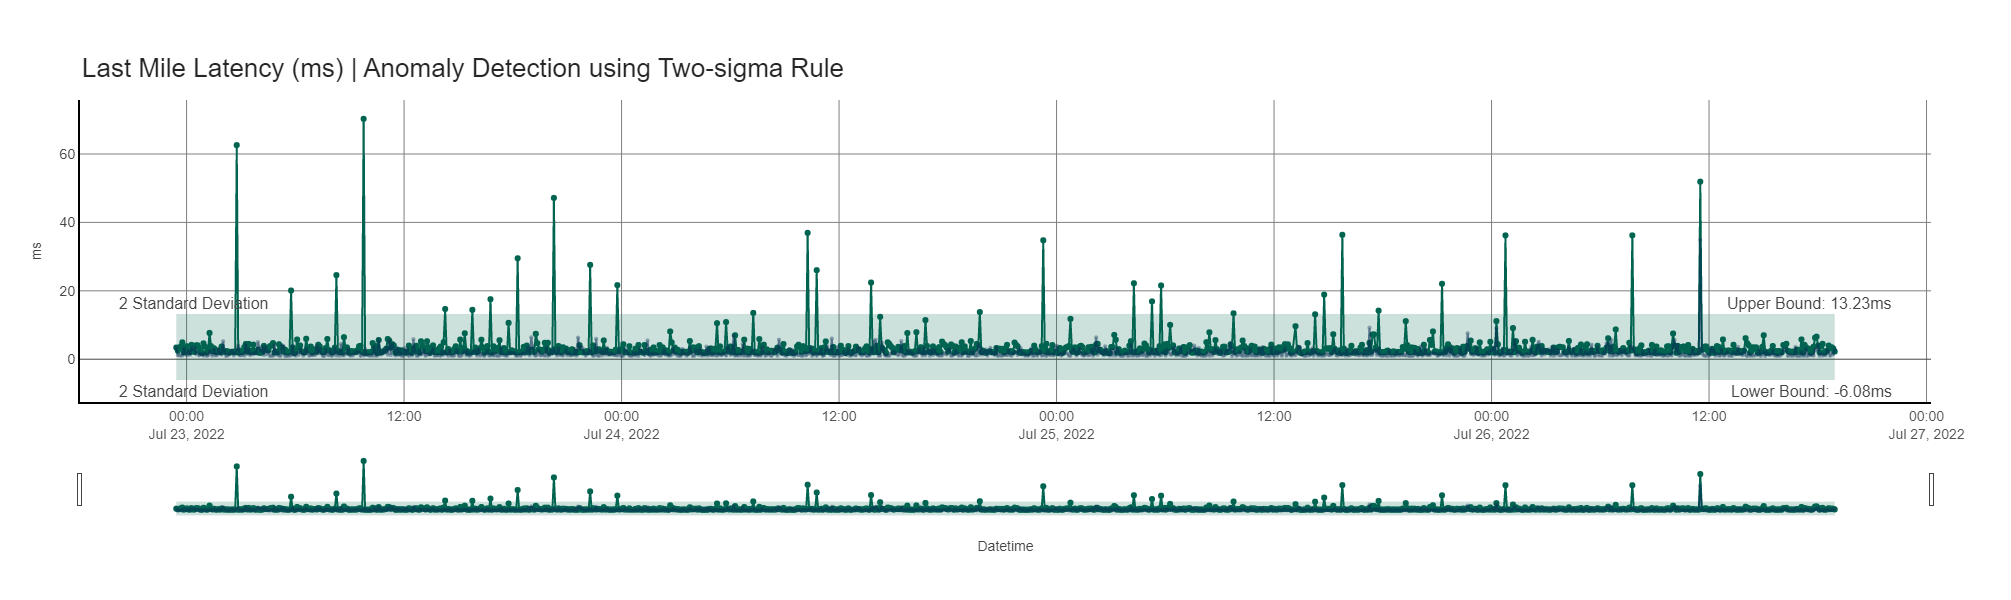

In [186]:
plot_lml_three_sigma_detection(df = lml_df,
                           last_x_days = 5,
                           date_col = 'datetime', 
                           y_col = 'last_mile_latency', 
                           num_sigma = 2
)

## Speed Tests / Throughputs

### Exploring the Trend (Re-cap)

In [84]:
# ADF Test
augmented_dickey_fuller_test(speed_df[(speed_df.pi == 'v1000')&(speed_df.direction == 'download')], 'speed')
# Print conclusion
print("----------------------------------------")
print("CONCLUSION: The download speed for V1000 has no trend or seasonality.")

Augmented Dickey-Fuller (ADF) Test: speed
ADF Statistic: -12.008218
Used Lag:  0
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
----------------------------------------
 => P-Value = 3.2263737272270125e-22. Rejecting Null Hypothesis.
 => Series is Stationary.
----------------------------------------
CONCLUSION: The download speed for V1000 has no trend or seasonality.


In [86]:
# ADF Test
augmented_dickey_fuller_test(speed_df[(speed_df.pi == 'v1000')&(speed_df.direction == 'upload')], 'speed')
# Print conclusion
print("----------------------------------------")
print("CONCLUSION: The upload speed for V1000 has no trend or seasonality.")

Augmented Dickey-Fuller (ADF) Test: speed
ADF Statistic: -15.259555
Used Lag:  0
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
----------------------------------------
 => P-Value = 4.882148374680787e-28. Rejecting Null Hypothesis.
 => Series is Stationary.
----------------------------------------
CONCLUSION: The upload speed for V1000 has no trend or seasonality.


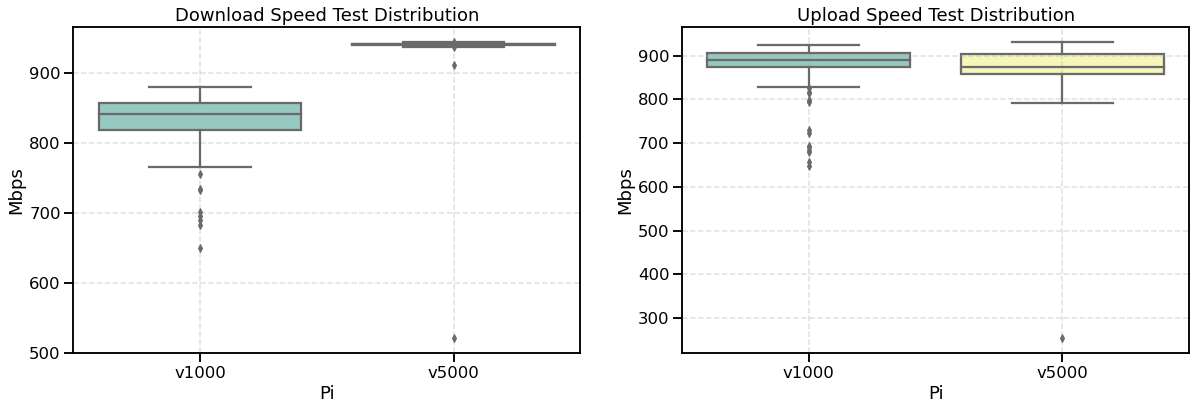

In [90]:
# Test outliers
f,axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.boxplot(x = 'pi', y = 'speed', data = speed_df[speed_df.direction == 'download'], palette="Set3", ax = axes[0])
axes[0].set_title("Download Speed Test Distribution")
axes[0].set_ylabel("Mbps")
axes[0].set_xlabel("Pi")
axes[0].grid(linestyle = "--", alpha=0.4)

sns.boxplot(x = 'pi', y = 'speed', data = speed_df[speed_df.direction == 'upload'], palette="Set3", ax = axes[1])
axes[1].set_title("Upload Speed Test Distribution")
axes[1].set_ylabel("Mbps")
axes[1].set_xlabel("Pi")
axes[1].grid(linestyle = "--", alpha=0.4)
plt.show()

In [209]:
stat = speed_df[speed_df.direction == 'download'].groupby('pi').agg(
    var_speed=pd.NamedAgg(column='speed', aggfunc=np.var),
    mean_speed=pd.NamedAgg(column='speed', aggfunc=np.mean),
)
stat['cv_speed'] = stat['var_speed']/stat['mean_speed']
stat

,var_speed,mean_speed,cv_speed
pi,,,
v1000,1300.667295,833.807903,1.559912
v5000,988.820793,938.784595,1.053299


In [210]:
stat = speed_df[speed_df.direction == 'upload'].groupby('pi').agg(
    var_speed=pd.NamedAgg(column='speed', aggfunc=np.var),
    mean_speed=pd.NamedAgg(column='speed', aggfunc=np.mean),
)
stat['cv_speed'] = stat['var_speed']/stat['mean_speed']
stat

,var_speed,mean_speed,cv_speed
pi,,,
v1000,2043.753618,880.042489,2.322335
v5000,2988.642509,875.306273,3.414396


### Anomaly Detection 

In [182]:
def plot_speed_three_sigma_detection(df, last_x_days, title_text, date_col, y_col, num_sigma = 2):
    '''
    Input:
        ...
    Output:
        fig1 (Plotly.graph figure object)
    '''    
    # filter out the anomaly records according to the user-specified thresholds
    data = df.loc[(df[date_col]>=(datetime.now()-timedelta(days=last_x_days)).strftime("%Y-%m-%d %H:%M:%S"))&(df.pi == 'v1000'),
                  [date_col,y_col]]
    v5000_data = df.loc[(df[date_col]>=(datetime.now()-timedelta(days=last_x_days)).strftime("%Y-%m-%d %H:%M:%S"))&(df.pi == 'v5000'),
                  [date_col,y_col]] 

    x = list(data[date_col])
    x_rev = x[::-1]
    y = list(data[y_col])
    y_upper = [(np.mean(y)+num_sigma*np.std(y))]*len(y)
    y_lower = [(np.mean(y)-num_sigma*np.std(y))]*len(y)
    # y_lower = y_lower[::-1]

    layout = Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig1 = go.Figure(layout = layout)
    # add the filled region
    fig1.add_trace(go.Scatter(
        x=x+x_rev,
        y=y_upper+y_lower,
        fill='toself',
        #fillcolor='rgba(0,100,80,0.2)',
        fillcolor='rgba(212,166,200,0.2)',
        line_color='rgba(255,255,255,0)',
        showlegend=False,
        hoverinfo='skip'
    ))
    # add the actual line
    fig1.add_trace(go.Scatter(
        x=x, y=y,
        #line_color='rgb(0,100,80)',
        line_color='rgb(176,122,161)',
        # name='Throughput',
        showlegend=False,
        hovertemplate =
          '<b>Wired + 60 GHz</b>' +
          '<br><b>Throughput: </b> %{y} Mbps'+
          '<br><b>Datetime: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
    ))
    # add the actual line - V5000
    fig1.add_trace(go.Scatter(
        x=list(v5000_data[date_col]), y=list(v5000_data[y_col]),
        line_color='rgb(128,138,135)',
        name='wired',
        opacity=.7, 
        marker={'size': 5, "opacity":.7},
        showlegend=False,
        hovertemplate =
          '<b>Wired</b>' +
          '<br><b>Throughput: </b> %{y} Mbps'+
          '<br><b>Datetime: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
    ))    
    
    # Set the layout
    fig1.update_layout(
        height=600,
        font_family="Arial",
        title_font_family="Arial",
        xaxis_title="Datetime",
        yaxis_title="Mbps",
        yaxis=dict(tickfont = dict(size=14)),
        xaxis=dict(    
            showline=True,
            showticklabels=True,
            linewidth=2,
            tickfont=dict(
                family='Arial',
                size=14,
                color='rgb(82, 82, 82)',
            ),
            rangeslider = dict(
                visible = True),
            type = "date"
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )
    annotations = []
    # Adding labels
    # For upper bound
    # labeling the left_side of the plot
    annotations.append(dict(xref='paper', x=0.02, y=y_upper[0],
                            xanchor='left', yanchor='bottom',
                            text=f'{num_sigma} Standard Deviation',
                            font=dict(family='Arial',
                            size=16),
                            showarrow=False))
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=0.98, y=y_upper[0],
                            xanchor='right', yanchor='bottom',
                            text=f'Upper Bound: {round(y_upper[0],2)} Mbps',
                            font=dict(family='Arial',
                            size=16),
                            showarrow=False))
    # For lower bound
    # labeling the left_side of the plot
    annotations.append(dict(xref='paper', x=0.02, y=y_lower[0],
                            xanchor='left', yanchor='top',
                            text=f'{num_sigma} Standard Deviation',
                            font=dict(family='Arial',
                            size=16),
                            showarrow=False))
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=0.98, y=y_lower[0],
                            xanchor='right', yanchor='top',
                            text=f'Lower Bound: {round(y_lower[0],2)} Mbps',
                            font=dict(family='Arial',
                            size=16),
                            showarrow=False))
    # Title
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                  xanchor='left', yanchor='bottom',
                                  text=title_text,
                                  font=dict(family='Arial',
                                            size=26,
                                            color='rgb(37,37,37)'),
                                  showarrow=False))

    fig1.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig1.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig1.update_traces(mode='lines+markers')
    fig1.update_layout(annotations=annotations)
    
    print(f"Among {len(data)} records, there are {len(data[(data[y_col]<y_lower[0])|(data[y_col]>y_upper[0])])}(~{round(len(data[(data[y_col]<y_lower[0])|(data[y_col]>y_upper[0])])/len(data),2)*100}%) anomalies outside of the 2-sigma bounds.")
    return fig1

Among 163 records, there are 6(~4.0%) anomalies outside of the 2-sigma bounds.


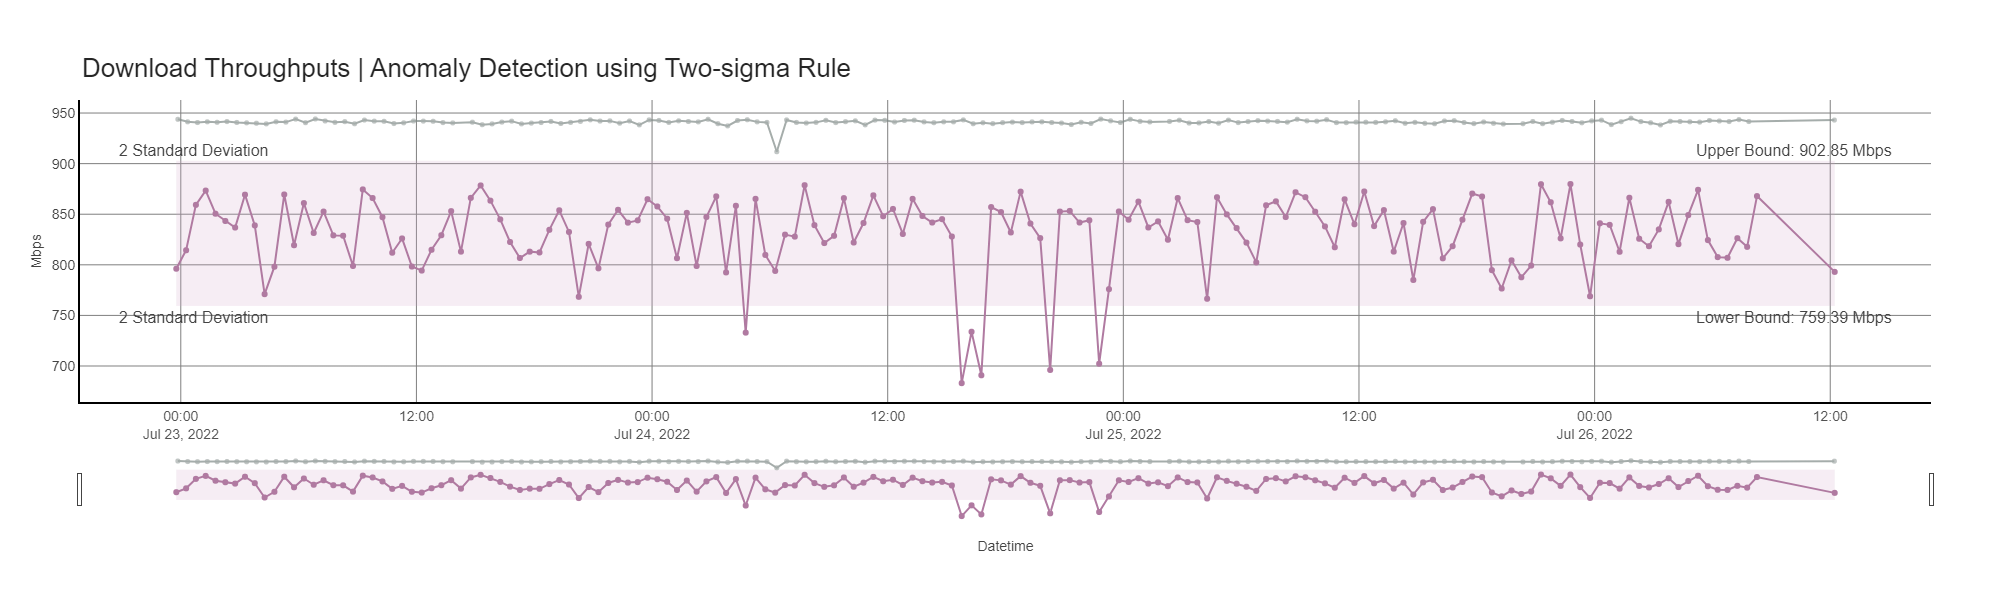

In [183]:
plot_speed_three_sigma_detection(df = speed_df[(speed_df.direction == 'download')],
                           last_x_days = 5,
                           date_col = 'datetime', 
                           y_col = 'speed', 
                           title_text = 'Download Throughputs | Anomaly Detection using Two-sigma Rule',
                           num_sigma = 2
)

Among 163 records, there are 7(~4.0%) anomalies outside of the 2-sigma bounds.


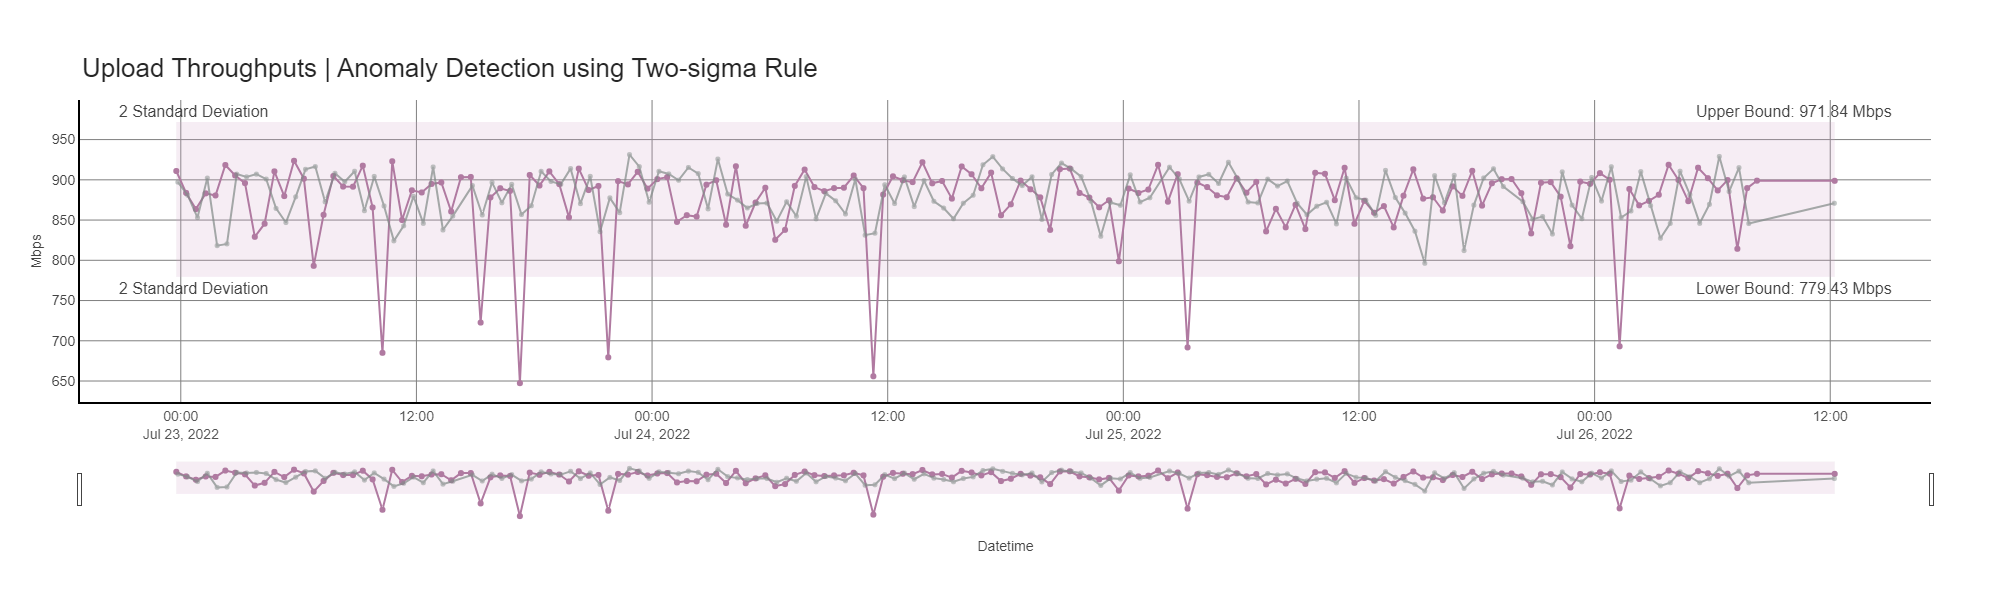

In [184]:
plot_speed_three_sigma_detection(df = speed_df[(speed_df.direction == 'upload')],
                           last_x_days = 5,
                           date_col = 'datetime', 
                           y_col = 'speed', 
                           title_text = 'Upload Throughputs | Anomaly Detection using Two-sigma Rule',
                           num_sigma = 2
)

# Appendix

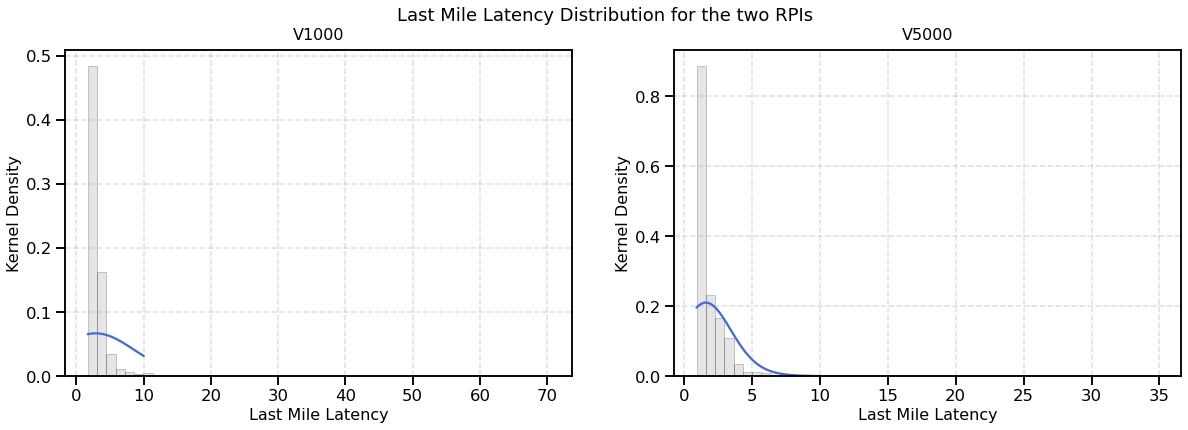

In [71]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.suptitle("Last Mile Latency Distribution for the two RPIs", fontsize = 18)
def plot_dist(data, title, ax_ind, bw_adjust = 5, clip = (0.0,10.0), color = 'royalblue', bins = 50, xlabel = 'Last Mile Latency', ylabel = 'Kernel Density'):
    """
    This dist_plot function visualizes the distribution of the data in histograms and KDE curve. 
    
    Input:
        data: pandas series. The variable.
        title: string. Title of the graph.
        ax_ind: index for the ax instance
    Output:
        None
    """  
    sns.distplot(data,
                # label = 'Sentiment', 
                ax = axes[ax_ind], 
                color = 'royalblue',
                bins = bins,  
                kde = True,               
                kde_kws = {                              
                    'bw_adjust': bw_adjust, # Important parameter!
                    # Factor, multiplied by the smoothing bandwidth, that determines how far the evaluation grid extends past the extreme datapoints. 
                    # When set to 0, truncate the curve at the data limits.
                    'cut': 0,  # Important parameter!
                    'clip': clip   # Important parameter!
                },
                hist_kws={
                    'histtype': 'bar',
                    'color': 'grey',   
                    'edgecolor': 'black',               
                    'linewidth': 1,    
                    'alpha': 0.2
                }                                
    )
    axes[ax_ind].set_title(title, fontsize = 16, pad = 10)
    axes[ax_ind].set_xlabel(xlabel, fontsize = 16)
    axes[ax_ind].set_ylabel(ylabel, fontsize = 16)
    axes[ax_ind].grid(linestyle = "--", alpha=0.4)

plot_dist(lml_df.loc[lml_df.pi == 'v1000','last_mile_latency'], 'V1000', 0)
plot_dist(lml_df.loc[lml_df.pi == 'v5000','last_mile_latency'], 'V5000', 1)

In [24]:
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet import Prophet

# Python
m = Prophet(
      interval_width = 0.98,
      changepoint_prior_scale = 2,
      changepoint_range=0.8,    
      growth = 'linear',
      weekly_seasonality = False,
      daily_seasonality = False,
      yearly_seasonality = False    
)
prophet_df = df.loc[df.datetime>'2022-07-17',['datetime','last_mile_latency']]
prophet_df.columns = ['ds','y']    
# prophet_df['ds'] = list(map(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), prophet_df['ds']))
# prophet_df = prophet_df.groupby("ds").y.mean().reset_index()
m.fit(prophet_df)

future = m.make_future_dataframe(periods = 40, freq = 'H')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Initial log joint probability = -5.10355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10611.1     0.0129654       1275.22           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10616.3     0.0127033       164.338           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10619.3    0.00258564       176.815           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10620.4    0.00548495       301.792      0.3997      0.3997      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         10621    0.00118755       27.9319           1           1      613   
    Iter      log prob        ||dx||      ||grad||       alpha  

,ds,yhat,yhat_lower,yhat_upper
3626,2022-07-28 20:16:00,1.787592,-7.581962,12.568985
3627,2022-07-28 21:16:00,1.773207,-8.628259,12.435414
3628,2022-07-28 22:16:00,1.758822,-8.079216,12.510996
3629,2022-07-28 23:16:00,1.744437,-7.963179,12.994894
3630,2022-07-29 00:16:00,1.730052,-10.015507,12.988229


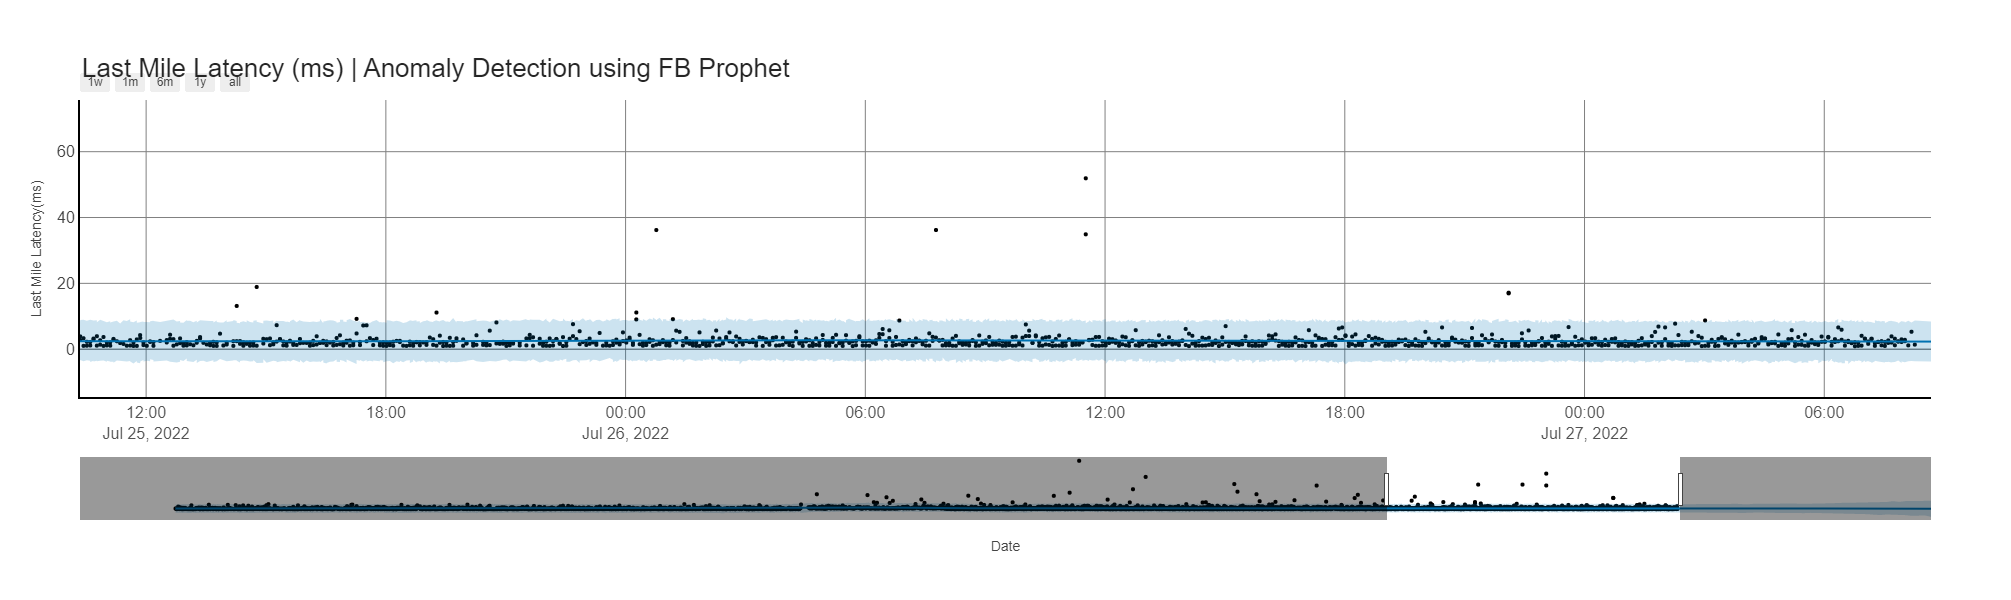

In [27]:
# Set the layout
layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig = go.Figure(layout = layout)
fig = plot_plotly(
    m, 
    forecast
)

fig.update_layout(
    font_family="Arial",
    height = 600,
    title_font_family="Arial",
    xaxis_title="Date",
    yaxis_title="Last Mile Latency(ms)",
    xaxis=dict(    
        showline=True,
        showticklabels=True,
        linewidth=2,
        tickfont=dict(
            family='Arial',
            size=16,
            color='rgb(82, 82, 82)',
        ),
        rangeslider = dict(
            visible = True),
        type = "date"
    ),
    yaxis = dict(tickfont = dict(size = 16)),
    hoverlabel=dict(
        bgcolor="white",
        font_size=14,
        font_family="Arial"
    )
)

# Title
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text=f'Last Mile Latency (ms) | Anomaly Detection using FB Prophet',
                              font=dict(family='Arial',
                                        size=26,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(annotations=annotations)


In [61]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from fbprophet import Prophet

# def get_ts_pred_rmse(y_true, y_pred, model_name):
#     rmse = mean_squared_error(y_true, 
#                             y_pred,
#                             squared=False)
#     print(f"RMSE for {model_name} on 20% validation set (11/04/2019~11/30/2019): {rmse}")
#     return rmse

def get_pred(train, valid, ts_col, y_col):
    FORECAST_TERM = len(valid)
    print("Number of future terms to forecast: ", FORECAST_TERM)

    arma_model = ARIMA(train[y_col], order=(2, 0, 1))
    arma_model_res = arma_model.fit()
    arma_pred = arma_model_res.forecast(FORECAST_TERM, alpha = 0.05) 
    arma_rmse = mean_squared_error(valid[y_col], arma_pred, squared=False)  

    es_fit = ExponentialSmoothing(
      train[[ts_col,y_col]].set_index(ts_col),
      trend="add",
      damped_trend = True,
      initialization_method="estimated",
    ).fit()
    es_pred = es_fit.forecast(FORECAST_TERM)
    es_rmse = mean_squared_error(valid[y_col], es_pred, squared=False)

    prophet_train = train[[ts_col, y_col]]
    prophet_train.columns = ['ds','y']    
    # Build the model
    prophet_model = Prophet(
      interval_width = 0.95,
      changepoint_prior_scale = 1.5,
      growth = 'linear',
      weekly_seasonality = False,
      daily_seasonality = False,
      yearly_seasonality = False
    )
    # prophet_model.add_country_holidays(country_name='US')
    # prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.01)
    prophet_model.fit(prophet_train)
    future_dt = prophet_model.make_future_dataframe(periods=FORECAST_TERM)
    prophet_pred = prophet_model.predict(future_dt)
    prophet_rmse = mean_squared_error(valid[y_col], prophet_pred.yhat[-FORECAST_TERM:],squared=False)

    model_lst = ['ARMA','EM','FB Prophet']
    rmse_lst = [arma_rmse, es_rmse, prophet_rmse]
    df = pd.DataFrame(columns = ['RMSE'],index=model_lst)    
    df['RMSE'] = rmse_lst
    return (df.sort_values(by='RMSE'),list(arma_pred),list(es_pred),list(prophet_pred.yhat[-FORECAST_TERM:]))

# ------------------------------------------------------------------------
# ========================================================================
def plot_ts_detection(data, recent_hours_filter, ts_col, y_col):
    '''
    Input:
        data
        pred_rate_range
        ...
    Output:
        fig2 (Plotly.graph figure object)
    '''           
    train = data.loc[(data[ts_col]<=(datetime.now()-timedelta(hours=recent_hours_filter)).strftime("%Y-%m-%d %H:%M:%S")),
        [ts_col,y_col]]    
    pred = data.loc[(data[ts_col]>=(datetime.now()-timedelta(hours=recent_hours_filter)).strftime("%Y-%m-%d %H:%M:%S")),
        [ts_col,y_col]]

    (rmse_df, arma_pred, es_pred, prophet_pred) = get_pred(train, pred, ts_col, y_col)
    print(rmse_df)

    layout = Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig2 = go.Figure(layout = layout)

    # add the actual scatter points
    fig2.add_trace(go.Scatter(
        x=list(pred[ts_col]), y=list(pred[y_col]),
        line_color='#393536',
        mode = 'markers',
        name='Actual Last Mile Latency',
        showlegend=True,
        hovertemplate =
          '<b>Last Mile Latency: </b> %{y} ms'+
          '<br><b>Datetime: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
    ))

    # add ARMA predictions
    fig2.add_trace(go.Scatter(
        x=list(pred[ts_col]), y=arma_pred,
        line_color='#113932',
        mode = 'lines+markers',
        name='ARMA',
        showlegend=True,
        hovertemplate =
          '<b>ARMA Predicted: Last Mile Latency: </b> %{y} ms'+
          '<br><b>Datetime: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
    ))

    # add Double Exponential Smoothing predictions
    fig2.add_trace(go.Scatter(
        x=list(pred[ts_col]), y=es_pred,
        line_color='#547e2a',
        mode = 'lines+markers',
        name='Double Exponential Smoothing',
        showlegend=True,
        hovertemplate =
          '<b>DEM Predicted: Last Mile Latency: </b> %{y} ms'+
          '<br><b>Datetime: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
    ))

    # add FB Prophet predictions
    fig2.add_trace(go.Scatter(
        x=list(pred[ts_col]), y=prophet_pred,
        line_color='#ffa600',
        mode = 'lines+markers',
        name='FB Prophet',
        showlegend=True,
        hovertemplate =
          '<b>FB Prophet Predicted: Last Mile Latency: </b> %{y} ms'+
          '<br><b>Datetime: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
    ))

    # Set the layout
    fig2.update_layout(
        font_family="Arial",
        height = 600,
        title_font_family="Arial",
        xaxis_title="Date",
        yaxis_title="Last Mile Latency",
        xaxis=dict(    
            showline=True,
            showticklabels=True,
            linewidth=2,
            tickfont=dict(
                family='Arial',
                size=16,
                color='rgb(82, 82, 82)',
            ),
            rangeslider = dict(
                visible = True),
            type = "date"
        ),
        yaxis = dict(tickfont = dict(size = 16)),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14,
            font_family="Arial"
        )
    )

    # Title
    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                  xanchor='left', yanchor='bottom',
                                  text=f'Last Mile Latency (ms) for Last {recent_hours_filter} Hours | Anomaly Detection using Three-sigma Rule',
                                  font=dict(family='Arial',
                                            size=26,
                                            color='rgb(37,37,37)'),
                                  showarrow=False))

    fig2.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig2.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig2.update_layout(annotations=annotations)
    return fig2

Number of future terms to forecast:  360
Initial log joint probability = -4.62066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       13523.3   0.000873601       154.878     0.09389           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       13524.3    0.00204369       142.424           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       13525.4     0.0171992       85.0179           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       13525.7    0.00070827       32.2695           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       13526.1    0.00472671        125.83      0.4429           1      586   
    Iter      log prob 

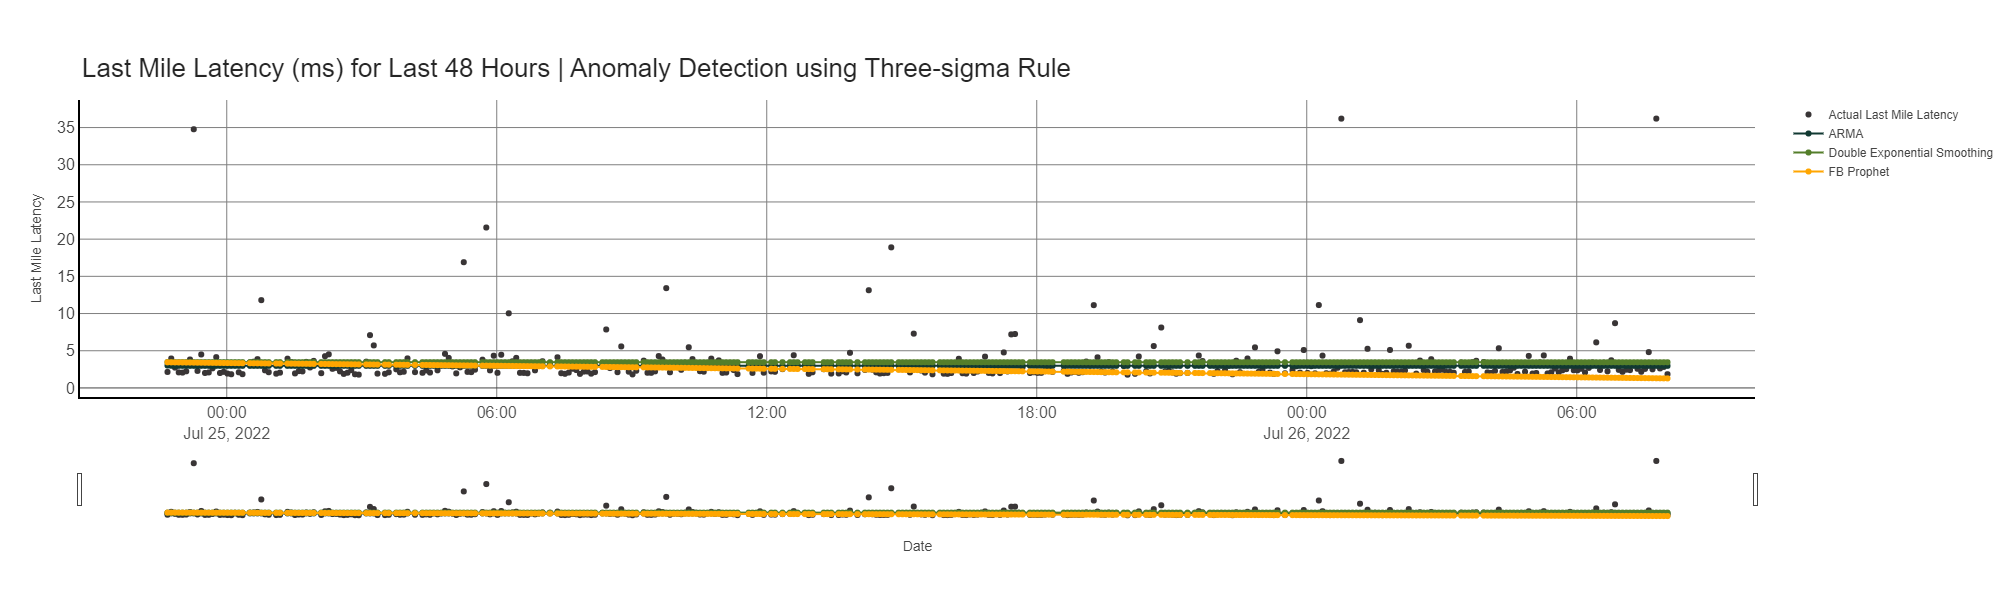

In [62]:
plot_ts_detection(df[df.pi=='v1000'], 48, 'datetime', 'last_mile_latency')